# EDA of the roads network

In [1]:
# Imports
import pandas as pd

# Print dataframes compact by displaying max 7 rows
pd.options.display.max_rows = 7

## Read the CSV as dataframe

In [2]:
roads = pd.read_csv('../data/interim/roads_file.csv', index_col=False, delimiter=';')

In [3]:
roads

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 990,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,91.36575,LRP145a,23.029416,91.365639,LRP146,23.026972,91.3655,LRP146a,23.024833,91.365528
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.623360,LRP001a,22.590027,90.631360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.620305,90.668999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884,Z8943,LRPS,22.426444,90.849472,LRPSa,22.426416,90.846833,LRP001,22.425444,90.839861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create dataframe by road

In [4]:
road = {}

In [5]:
sel_road = 'N1'
road[sel_road] = roads.loc[roads['road'] == sel_road]
road[sel_road]

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 990,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,91.36575,LRP145a,23.029416,91.365639,LRP146,23.026972,91.3655,LRP146a,23.024833,91.365528


In [6]:
def dataframe_per_road(single_row_df):
    # Create a series from the single-row dataframe
    series = single_row_df.iloc[0 , 1:]

    # Create an empty dataframe with 3 columns
    new_df = pd.DataFrame(columns=["name", "long", "lat"])

    # Fill that dataframe by splitting the series in sections of
    for i in range(len(series)//3):
        start = i*3
        end = (i+1)*3
        new_df.loc[i] = series.iloc[start:end].tolist()
    return new_df

In [7]:
dataframe_per_road(road[sel_road])

,name,long,lat
0,LRPS,23.706028,90.443333
1,LRPSa,23.702917,90.450417
2,LRPSb,23.702778,90.450472
...,...,...,...
330,LRP145a,23.029416,91.365639
331,LRP146,23.026972,91.365500
332,LRP146a,23.024833,91.365528


## Create dictionary of dataframes for all roads

In [8]:
# Create an empty dictionary for all roads
road_df_dict = {}

# For each road, add a dataframe with the road segments to the dictionary
for road in roads['road'].tolist()[:20]:
    single_row_df = roads.loc[roads['road'] == road]
    road_df_dict[road] = dataframe_per_road(single_row_df)

In [9]:
road_df_dict['N1']

,name,long,lat
0,LRPS,23.706028,90.443333
1,LRPSa,23.702917,90.450417
2,LRPSb,23.702778,90.450472
...,...,...,...
330,LRP145a,23.029416,91.365639
331,LRP146,23.026972,91.365500
332,LRP146a,23.024833,91.365528


## Detect and replace outliers

### Ideas
 - Using a moving average [link](https://stackoverflow.com/questions/46964363/filtering-out-outliers-in-pandas-dataframe-with-rolling-median)
 - Classification and Regression Trees (Isolation Forest) in scikit-learn
 - Isolation Forest in PyCaret [link](https://towardsdatascience.com/time-series-anomaly-detection-with-pycaret-706a6e2b2427)
 - TODS: Automated Time-series Outlier Detection System [link](https://github.com/datamllab/tods)
 - Using Facebook Prophet [link](https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/)

Other ideas: [Anomaly Detection in Time Series](https://neptune.ai/blog/anomaly-detection-in-time-series)

In [10]:
window = 7 # Rolling windows length, 7 means looking 3 back and 3 forth
test_df = road_df_dict['N1']

In [11]:
# Add median and std values to dataframe
for a in ['long', 'lat']:
    test_df[f'median_{a}']= test_df[a].rolling(window, center=True, min_periods=3).median()
    test_df[f'std_{a}'] = test_df[a].rolling(window, center=True, min_periods=3).std()
test_df

,name,long,lat,median_long,std_long,median_lat,std_lat
0,LRPS,23.706028,90.443333,23.702847,0.001742,90.450444,0.003878
1,LRPSa,23.702917,90.450417,23.702778,0.002915,90.450472,0.006155
2,LRPSb,23.702778,90.450472,23.702458,0.003308,90.451222,0.006930
...,...,...,...,...,...,...,...
330,LRP145a,23.029416,91.365639,23.032722,0.007299,91.365569,0.000110
331,LRP146,23.026972,91.365500,23.029416,0.006300,91.365611,0.000099
332,LRP146a,23.024833,91.365528,23.028194,0.004853,91.365583,0.000114


<AxesSubplot:>

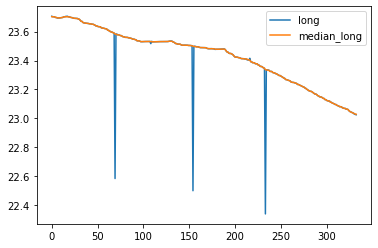

In [12]:
test_df[["long", "median_long"]].plot()